In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import import_ipynb
import random
import timeit

In [3]:
%run vis-transformer.ipynb

Using device: cuda
torch.Size([512, 50, 16])
torch.Size([512, 10])


- training parameters

In [14]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 50
LEARNING_RATE = 0.0001
ADAM_WEIGHT_DECAY = 0.0001
ADAM_BETAS = (0.9, 0.999)
# early stopping
PATIENCE = 3  

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

- data

In [5]:
train_df = pd.read_csv('digit-recognizer/train.csv')
test_df = pd.read_csv('digit-recognizer/test.csv')
submission_df = pd.read_csv("digit-recognizer/sample_submission.csv")

In [6]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [9]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)) # mean and std of MNIST dataset
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {'image': image, 'label': label, 'index': index}
    
class MNISTValidationDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {'image': image, 'label': label, 'index': index}
    
class MNISTSubmissionDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {'image': image, 'index': index}

37800
4200
28000


<Figure size 640x480 with 0 Axes>

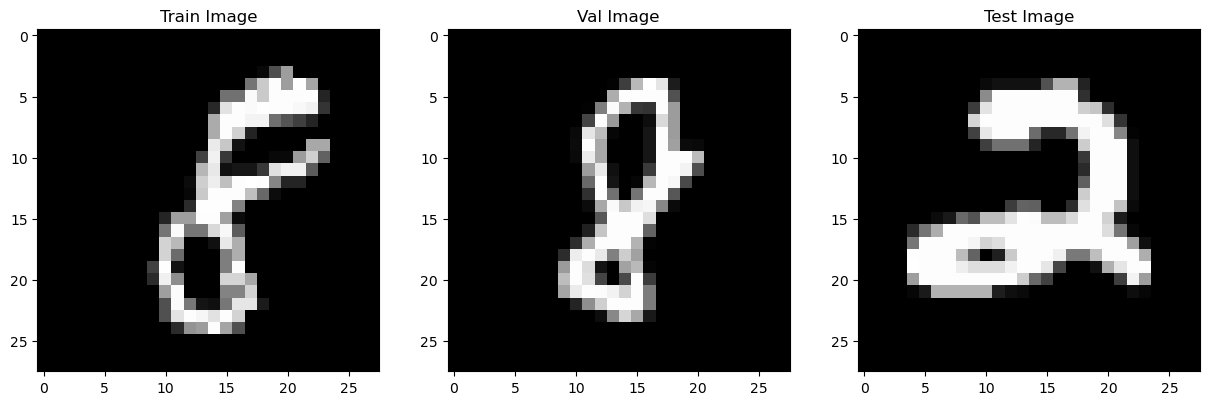

In [10]:
plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(15, 7))

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
#print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")

val_dataset = MNISTValidationDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
#print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")

test_dataset = MNISTSubmissionDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
#print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")

plt.show()

In [11]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [15]:
# TRAINING
device = "cuda" if torch.cuda.is_available() else "cpu"
# model from vis-transformer.ipynb
model = ViT(NUM_CLASSES, IMAGE_SIZE, HIDDEN_DIM, NUM_HEADS, NUM_ENCODER_LAYERS, DROPOUT, PATCH_SIZE, NUM_PATCHES, EMBEDDING_DIM, ACTIVATION, IN_CHANNELS) # type: ignore
model = model.to(device)

# early stopping
best_val_loss = float('inf')  
epochs_without_improvement = 0  

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_predictions = []
    train_loss = 0.0

    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        image = img_label['image'].float().to(device)
        label = img_label['label'].type(torch.uint8).to(device)
        
        y_pred = model(image)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_predictions.extend(y_pred_label.cpu().detach())

        optimizer.zero_grad()
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_epoch_loss = train_loss / (idx+1)

    # EVALUATION
    model.eval()
    val_labels = []
    val_predictions = []
    val_loss = 0.0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_predictions.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_loss += loss.item()
    val_epoch_loss = val_loss / (idx + 1)

    print(f"Train loss for EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid loss for EPOCH {epoch+1}: {val_epoch_loss:.4f}")
    print(f"Train accuracy for EPOCH {epoch+1}: {sum(1 for x,y in zip(train_predictions, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid accuracy for EPOCH {epoch+1}: {sum(1 for x,y in zip(val_predictions, val_labels) if x == y) / len(val_labels):.4f}")

    # Early stopping
    if val_epoch_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_epoch_loss:.4f}. Model saving...")
        best_val_loss = val_epoch_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{PATIENCE}")
        if epochs_without_improvement >= PATIENCE:
            print(f"Early stopping after {PATIENCE} epochs without improvement.")
            break


stop = timeit.default_timer()
print(f"Training time: {stop-start:.2f}s")

100%|██████████| 9/9 [00:00<00:00, 13.26it/s]


Train loss for EPOCH 1: 170.3997
Valid loss for EPOCH 1: 2.2543


  2%|▏         | 1/50 [00:19<15:57, 19.54s/it]

Train accuracy for EPOCH 1: 0.1378
Valid accuracy for EPOCH 1: 0.1976
Validation loss improved from inf to 2.2543. Model saving...


100%|██████████| 9/9 [00:00<00:00, 12.78it/s]


Train loss for EPOCH 2: 160.6685
Valid loss for EPOCH 2: 2.0239


  4%|▍         | 2/50 [00:38<15:17, 19.12s/it]

Train accuracy for EPOCH 2: 0.2347
Valid accuracy for EPOCH 2: 0.3069
Validation loss improved from 2.2543 to 2.0239. Model saving...


100%|██████████| 9/9 [00:00<00:00, 12.36it/s]


Train loss for EPOCH 3: 145.8589
Valid loss for EPOCH 3: 1.7487


  6%|▌         | 3/50 [00:57<14:56, 19.08s/it]

Train accuracy for EPOCH 3: 0.3117
Valid accuracy for EPOCH 3: 0.4260
Validation loss improved from 2.0239 to 1.7487. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.78it/s]


Train loss for EPOCH 4: 134.9806
Valid loss for EPOCH 4: 1.6164


  8%|▊         | 4/50 [01:15<14:28, 18.88s/it]

Train accuracy for EPOCH 4: 0.3676
Valid accuracy for EPOCH 4: 0.4843
Validation loss improved from 1.7487 to 1.6164. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.72it/s]


Train loss for EPOCH 5: 128.4881
Valid loss for EPOCH 5: 1.5472


 10%|█         | 5/50 [01:33<13:42, 18.27s/it]

Train accuracy for EPOCH 5: 0.4019
Valid accuracy for EPOCH 5: 0.5240
Validation loss improved from 1.6164 to 1.5472. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.06it/s]


Train loss for EPOCH 6: 123.7609
Valid loss for EPOCH 6: 1.4687


 12%|█▏        | 6/50 [01:50<13:09, 17.95s/it]

Train accuracy for EPOCH 6: 0.4281
Valid accuracy for EPOCH 6: 0.5498
Validation loss improved from 1.5472 to 1.4687. Model saving...


100%|██████████| 9/9 [00:00<00:00, 11.45it/s]


Train loss for EPOCH 7: 119.3590
Valid loss for EPOCH 7: 1.3503


 14%|█▍        | 7/50 [02:07<12:42, 17.74s/it]

Train accuracy for EPOCH 7: 0.4505
Valid accuracy for EPOCH 7: 0.5955
Validation loss improved from 1.4687 to 1.3503. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.35it/s]


Train loss for EPOCH 8: 115.6152
Valid loss for EPOCH 8: 1.3199


 16%|█▌        | 8/50 [02:25<12:19, 17.60s/it]

Train accuracy for EPOCH 8: 0.4706
Valid accuracy for EPOCH 8: 0.6026
Validation loss improved from 1.3503 to 1.3199. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.75it/s]


Train loss for EPOCH 9: 111.7520
Valid loss for EPOCH 9: 1.2621


 18%|█▊        | 9/50 [02:42<11:57, 17.49s/it]

Train accuracy for EPOCH 9: 0.4880
Valid accuracy for EPOCH 9: 0.6188
Validation loss improved from 1.3199 to 1.2621. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.31it/s]


Train loss for EPOCH 10: 108.3815
Valid loss for EPOCH 10: 1.1745


 20%|██        | 10/50 [02:59<11:34, 17.37s/it]

Train accuracy for EPOCH 10: 0.5026
Valid accuracy for EPOCH 10: 0.6448
Validation loss improved from 1.2621 to 1.1745. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.26it/s]


Train loss for EPOCH 11: 104.8509
Valid loss for EPOCH 11: 1.1250


 22%|██▏       | 11/50 [03:16<11:16, 17.33s/it]

Train accuracy for EPOCH 11: 0.5235
Valid accuracy for EPOCH 11: 0.6669
Validation loss improved from 1.1745 to 1.1250. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.37it/s]


Train loss for EPOCH 12: 101.9269
Valid loss for EPOCH 12: 1.0672


 24%|██▍       | 12/50 [03:34<10:59, 17.35s/it]

Train accuracy for EPOCH 12: 0.5311
Valid accuracy for EPOCH 12: 0.6893
Validation loss improved from 1.1250 to 1.0672. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


Train loss for EPOCH 13: 98.6705
Valid loss for EPOCH 13: 1.0367


 26%|██▌       | 13/50 [03:51<10:43, 17.38s/it]

Train accuracy for EPOCH 13: 0.5498
Valid accuracy for EPOCH 13: 0.7064
Validation loss improved from 1.0672 to 1.0367. Model saving...


100%|██████████| 9/9 [00:00<00:00, 12.56it/s]


Train loss for EPOCH 14: 96.3009
Valid loss for EPOCH 14: 0.9892


 28%|██▊       | 14/50 [04:11<10:48, 18.03s/it]

Train accuracy for EPOCH 14: 0.5621
Valid accuracy for EPOCH 14: 0.7119
Validation loss improved from 1.0367 to 0.9892. Model saving...


100%|██████████| 9/9 [00:00<00:00, 11.92it/s]


Train loss for EPOCH 15: 93.9333
Valid loss for EPOCH 15: 0.9848


 30%|███       | 15/50 [04:31<10:52, 18.65s/it]

Train accuracy for EPOCH 15: 0.5730
Valid accuracy for EPOCH 15: 0.7000
Validation loss improved from 0.9892 to 0.9848. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.20it/s]


Train loss for EPOCH 16: 91.3560
Valid loss for EPOCH 16: 0.9803


 32%|███▏      | 16/50 [04:49<10:33, 18.62s/it]

Train accuracy for EPOCH 16: 0.5822
Valid accuracy for EPOCH 16: 0.6895
Validation loss improved from 0.9848 to 0.9803. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.68it/s]


Train loss for EPOCH 17: 89.9971
Valid loss for EPOCH 17: 0.8914


 34%|███▍      | 17/50 [05:08<10:15, 18.64s/it]

Train accuracy for EPOCH 17: 0.5884
Valid accuracy for EPOCH 17: 0.7357
Validation loss improved from 0.9803 to 0.8914. Model saving...


100%|██████████| 9/9 [00:00<00:00, 11.95it/s]


Train loss for EPOCH 18: 87.7893
Valid loss for EPOCH 18: 0.8901


 36%|███▌      | 18/50 [05:25<09:45, 18.29s/it]

Train accuracy for EPOCH 18: 0.6012
Valid accuracy for EPOCH 18: 0.7310
Validation loss improved from 0.8914 to 0.8901. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.44it/s]


Train loss for EPOCH 19: 85.3289
Valid loss for EPOCH 19: 0.8693


 38%|███▊      | 19/50 [05:43<09:22, 18.15s/it]

Train accuracy for EPOCH 19: 0.6088
Valid accuracy for EPOCH 19: 0.7452
Validation loss improved from 0.8901 to 0.8693. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.97it/s]


Train loss for EPOCH 20: 84.0372
Valid loss for EPOCH 20: 0.8337


 40%|████      | 20/50 [06:01<08:59, 17.98s/it]

Train accuracy for EPOCH 20: 0.6148
Valid accuracy for EPOCH 20: 0.7579
Validation loss improved from 0.8693 to 0.8337. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.61it/s]


Train loss for EPOCH 21: 81.4577
Valid loss for EPOCH 21: 0.8097


 42%|████▏     | 21/50 [06:18<08:37, 17.85s/it]

Train accuracy for EPOCH 21: 0.6305
Valid accuracy for EPOCH 21: 0.7560
Validation loss improved from 0.8337 to 0.8097. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.52it/s]


Train loss for EPOCH 22: 80.5927
Valid loss for EPOCH 22: 0.7769


 44%|████▍     | 22/50 [06:36<08:17, 17.77s/it]

Train accuracy for EPOCH 22: 0.6333
Valid accuracy for EPOCH 22: 0.7624
Validation loss improved from 0.8097 to 0.7769. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.61it/s]


Train loss for EPOCH 23: 79.7411
Valid loss for EPOCH 23: 0.7819


 46%|████▌     | 23/50 [06:54<07:59, 17.74s/it]

Train accuracy for EPOCH 23: 0.6350
Valid accuracy for EPOCH 23: 0.7631
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 13.95it/s]


Train loss for EPOCH 24: 77.9846
Valid loss for EPOCH 24: 0.7791


 48%|████▊     | 24/50 [07:11<07:37, 17.58s/it]

Train accuracy for EPOCH 24: 0.6458
Valid accuracy for EPOCH 24: 0.7688
Validation loss did not improve. Patience: 2/3


100%|██████████| 9/9 [00:00<00:00, 12.92it/s]


Train loss for EPOCH 25: 77.1949
Valid loss for EPOCH 25: 0.7346


 50%|█████     | 25/50 [07:28<07:18, 17.54s/it]

Train accuracy for EPOCH 25: 0.6493
Valid accuracy for EPOCH 25: 0.7833
Validation loss improved from 0.7769 to 0.7346. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.07it/s]


Train loss for EPOCH 26: 75.0698
Valid loss for EPOCH 26: 0.7117


 52%|█████▏    | 26/50 [07:46<07:00, 17.54s/it]

Train accuracy for EPOCH 26: 0.6607
Valid accuracy for EPOCH 26: 0.7919
Validation loss improved from 0.7346 to 0.7117. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.41it/s]


Train loss for EPOCH 27: 72.8403
Valid loss for EPOCH 27: 0.6827


 54%|█████▍    | 27/50 [08:03<06:41, 17.48s/it]

Train accuracy for EPOCH 27: 0.6722
Valid accuracy for EPOCH 27: 0.8017
Validation loss improved from 0.7117 to 0.6827. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.99it/s]


Train loss for EPOCH 28: 72.1029
Valid loss for EPOCH 28: 0.6858


 56%|█████▌    | 28/50 [08:21<06:25, 17.50s/it]

Train accuracy for EPOCH 28: 0.6756
Valid accuracy for EPOCH 28: 0.8029
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 14.14it/s]


Train loss for EPOCH 29: 71.2440
Valid loss for EPOCH 29: 0.6714


 58%|█████▊    | 29/50 [08:38<06:07, 17.49s/it]

Train accuracy for EPOCH 29: 0.6792
Valid accuracy for EPOCH 29: 0.7990
Validation loss improved from 0.6827 to 0.6714. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.46it/s]


Train loss for EPOCH 30: 70.3663
Valid loss for EPOCH 30: 0.6649


 60%|██████    | 30/50 [08:56<05:50, 17.51s/it]

Train accuracy for EPOCH 30: 0.6816
Valid accuracy for EPOCH 30: 0.7986
Validation loss improved from 0.6714 to 0.6649. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.82it/s]


Train loss for EPOCH 31: 68.9478
Valid loss for EPOCH 31: 0.6485


 62%|██████▏   | 31/50 [09:13<05:32, 17.48s/it]

Train accuracy for EPOCH 31: 0.6898
Valid accuracy for EPOCH 31: 0.8148
Validation loss improved from 0.6649 to 0.6485. Model saving...


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


Train loss for EPOCH 32: 67.4323
Valid loss for EPOCH 32: 0.6395


 64%|██████▍   | 32/50 [09:31<05:19, 17.75s/it]

Train accuracy for EPOCH 32: 0.6974
Valid accuracy for EPOCH 32: 0.8098
Validation loss improved from 0.6485 to 0.6395. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.13it/s]


Train loss for EPOCH 33: 66.1138
Valid loss for EPOCH 33: 0.6274


 66%|██████▌   | 33/50 [09:50<05:05, 17.96s/it]

Train accuracy for EPOCH 33: 0.7051
Valid accuracy for EPOCH 33: 0.8229
Validation loss improved from 0.6395 to 0.6274. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.32it/s]


Train loss for EPOCH 34: 64.8119
Valid loss for EPOCH 34: 0.6176


 68%|██████▊   | 34/50 [10:07<04:44, 17.79s/it]

Train accuracy for EPOCH 34: 0.7108
Valid accuracy for EPOCH 34: 0.8162
Validation loss improved from 0.6274 to 0.6176. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.40it/s]


Train loss for EPOCH 35: 64.4346
Valid loss for EPOCH 35: 0.5897


 70%|███████   | 35/50 [10:24<04:24, 17.60s/it]

Train accuracy for EPOCH 35: 0.7130
Valid accuracy for EPOCH 35: 0.8338
Validation loss improved from 0.6176 to 0.5897. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.26it/s]


Train loss for EPOCH 36: 63.0422
Valid loss for EPOCH 36: 0.5757


 72%|███████▏  | 36/50 [10:42<04:05, 17.53s/it]

Train accuracy for EPOCH 36: 0.7191
Valid accuracy for EPOCH 36: 0.8243
Validation loss improved from 0.5897 to 0.5757. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.63it/s]


Train loss for EPOCH 37: 61.9261
Valid loss for EPOCH 37: 0.5650


 74%|███████▍  | 37/50 [10:59<03:47, 17.50s/it]

Train accuracy for EPOCH 37: 0.7225
Valid accuracy for EPOCH 37: 0.8402
Validation loss improved from 0.5757 to 0.5650. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.91it/s]


Train loss for EPOCH 38: 60.8547
Valid loss for EPOCH 38: 0.5574


 76%|███████▌  | 38/50 [11:17<03:29, 17.43s/it]

Train accuracy for EPOCH 38: 0.7304
Valid accuracy for EPOCH 38: 0.8417
Validation loss improved from 0.5650 to 0.5574. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.30it/s]


Train loss for EPOCH 39: 59.5359
Valid loss for EPOCH 39: 0.5928


 78%|███████▊  | 39/50 [11:34<03:11, 17.41s/it]

Train accuracy for EPOCH 39: 0.7360
Valid accuracy for EPOCH 39: 0.8212
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 13.53it/s]


Train loss for EPOCH 40: 59.5179
Valid loss for EPOCH 40: 0.5351


 80%|████████  | 40/50 [11:51<02:54, 17.43s/it]

Train accuracy for EPOCH 40: 0.7371
Valid accuracy for EPOCH 40: 0.8376
Validation loss improved from 0.5574 to 0.5351. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.06it/s]


Train loss for EPOCH 41: 57.9918
Valid loss for EPOCH 41: 0.5401


 82%|████████▏ | 41/50 [12:09<02:37, 17.45s/it]

Train accuracy for EPOCH 41: 0.7439
Valid accuracy for EPOCH 41: 0.8355
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 13.85it/s]


Train loss for EPOCH 42: 56.5465
Valid loss for EPOCH 42: 0.5132


 84%|████████▍ | 42/50 [12:26<02:19, 17.41s/it]

Train accuracy for EPOCH 42: 0.7505
Valid accuracy for EPOCH 42: 0.8452
Validation loss improved from 0.5351 to 0.5132. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.45it/s]


Train loss for EPOCH 43: 56.5326
Valid loss for EPOCH 43: 0.5320


 86%|████████▌ | 43/50 [12:43<02:01, 17.36s/it]

Train accuracy for EPOCH 43: 0.7513
Valid accuracy for EPOCH 43: 0.8450
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 14.13it/s]


Train loss for EPOCH 44: 55.5677
Valid loss for EPOCH 44: 0.5096


 88%|████████▊ | 44/50 [13:01<01:43, 17.31s/it]

Train accuracy for EPOCH 44: 0.7535
Valid accuracy for EPOCH 44: 0.8538
Validation loss improved from 0.5132 to 0.5096. Model saving...


100%|██████████| 9/9 [00:00<00:00, 13.74it/s]


Train loss for EPOCH 45: 55.1922
Valid loss for EPOCH 45: 0.5039


 90%|█████████ | 45/50 [13:18<01:26, 17.32s/it]

Train accuracy for EPOCH 45: 0.7549
Valid accuracy for EPOCH 45: 0.8548
Validation loss improved from 0.5096 to 0.5039. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.14it/s]


Train loss for EPOCH 46: 53.5886
Valid loss for EPOCH 46: 0.4665


 92%|█████████▏| 46/50 [13:35<01:09, 17.33s/it]

Train accuracy for EPOCH 46: 0.7627
Valid accuracy for EPOCH 46: 0.8643
Validation loss improved from 0.5039 to 0.4665. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.18it/s]


Train loss for EPOCH 47: 53.7140
Valid loss for EPOCH 47: 0.4626


 94%|█████████▍| 47/50 [13:53<00:51, 17.30s/it]

Train accuracy for EPOCH 47: 0.7616
Valid accuracy for EPOCH 47: 0.8671
Validation loss improved from 0.4665 to 0.4626. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.43it/s]


Train loss for EPOCH 48: 52.1702
Valid loss for EPOCH 48: 0.4795


 96%|█████████▌| 48/50 [14:10<00:34, 17.32s/it]

Train accuracy for EPOCH 48: 0.7715
Valid accuracy for EPOCH 48: 0.8552
Validation loss did not improve. Patience: 1/3


100%|██████████| 9/9 [00:00<00:00, 11.48it/s]


Train loss for EPOCH 49: 51.9985
Valid loss for EPOCH 49: 0.4626


 98%|█████████▊| 49/50 [14:28<00:17, 17.43s/it]

Train accuracy for EPOCH 49: 0.7710
Valid accuracy for EPOCH 49: 0.8602
Validation loss improved from 0.4626 to 0.4626. Model saving...


100%|██████████| 9/9 [00:00<00:00, 14.44it/s]


Train loss for EPOCH 50: 50.6597
Valid loss for EPOCH 50: 0.4593


100%|██████████| 50/50 [14:45<00:00, 17.71s/it]

Train accuracy for EPOCH 50: 0.7779
Valid accuracy for EPOCH 50: 0.8705
Validation loss improved from 0.4626 to 0.4593. Model saving...
Training time: 885.42s


In [18]:
torch.cuda.empty_cache()

'''
Train accuracy for EPOCH 10: 0.4755
Valid accuracy for EPOCH 10: 0.6119
Validation loss improved from 1.3479 to 1.2864. Model saving...
Training time: 923.69s  (CPU)
'''

'''
Train accuracy for EPOCH 50: 0.7779
Valid accuracy for EPOCH 50: 0.8705
Validation loss improved from 0.4626 to 0.4593. Model saving...
Training time: 885.42s  (GPU)
'''

'\nTrain accuracy for EPOCH 50: 0.7779\nValid accuracy for EPOCH 50: 0.8705\nValidation loss improved from 0.4626 to 0.4593. Model saving...\nTraining time: 885.42s  (GPU)\n'